# scTour inference – Post-inference adjustment

## For version 0.1.3

This notebook shows how to perform post-inference adjustment when the returned pseudotime and vector field estimates are in the reversed order. The dataset from dentate gyrus neurogenesis is used here for demonstration.

In [1]:
import sctour as sct
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Import the data. The data can be downloaded from [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE95315).

In [2]:
info = pd.read_csv('../../../../GSE95315_10X_expression_data_v2.tab', index_col=0, sep='\t', nrows=2)
count = pd.read_csv('../../../../GSE95315_10X_expression_data_v2.tab', index_col=0, sep='\t', skiprows=[1, 2]).T
adata = sc.AnnData(X=count)
adata.obs['cluster'] = info.loc['cluster_name']

Here the focus is the granule cell lineage.

In [3]:
ind = adata.obs['cluster'].isin(['Granule-mature', 'Granule-immature', 'Neuroblast_2', 'Neuroblast_1', 'nIPC'])
adata = adata[ind, :]
adata.shape

(4007, 14545)

Relevel the cell type categories and assign colors to each cell type.

In [4]:
adata.obs['cluster'] = adata.obs['cluster'].astype('category')
adata.obs['cluster'].cat.reorder_categories(['nIPC', 'Neuroblast_1', 'Neuroblast_2', 'Granule-immature', 'Granule-mature'], inplace=True)

from matplotlib import cm, colors
cols = list(map(colors.to_hex, cm.tab20.colors))
adata.uns['cluster_colors'] = ['#aa40fc'] + [cols[i] for i in [3, 2, 1, 0]]

Trying to set attribute `.obs` of view, copying.


Count the number of genes detected in each cell. This step is required before the scTour model training.

In [5]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
adata.obs

,cluster,n_genes_by_counts,total_counts
10X46_1_ATACCTTGAAGCCT-1,nIPC,1108,1627.0
10X46_1_GAGGCAGACTTCGC-1,nIPC,2105,4504.0
10X43_1_ACTCGCACTACGAC-1,nIPC,1558,3252.0
10X46_1_ATCGGAACCAATCG-1,nIPC,1864,4005.0
10X46_1_TCAGCGCTCGTCTC-1,nIPC,1341,2968.0
...,...,...,...
10X46_1_ATTGAATGCTCAGA-1,Granule-mature,1000,1690.0
10X46_1_CAGGTTGAAAAAGC-1,Granule-mature,1213,2003.0
10X46_1_GCCAACCTGGAACG-1,Granule-mature,1155,1847.0
10X46_1_CCTCGAACAACCTG-1,Granule-mature,812,1281.0


Select highly variable genes.

In [6]:
sc.pp.filter_genes(adata, min_cells=20)
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=2000, subset=True)

/home/ql312/software/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


Now we are ready to train the scTour model. As shown in the *Using scTour to infer cellular dynamics* tutorial, users can adjust the parameter `percent` for the percentage of cells used to train the model.

In [7]:
tnode = sct.train.Trainer(adata, loss_mode='nb')
tnode.train()

Epoch 400: 100%|██████████| 400/400 [13:49<00:00,  2.02s/epoch, train_loss=553, val_loss=544]


Infer the developmental pseudotime and latent space. As shown in the *Using scTour to infer cellular dynamics* tutorial, users can adjust the two parameters 'alpha_z' and 'alpha_predz' based on their purposes.

In [8]:
adata.obs['ptime'] = tnode.get_time()
mix_zs, zs, pred_zs = tnode.get_latentsp(alpha_z=0.2, alpha_predz=0.8)
adata.obsm['X_TNODE'] = mix_zs

Generate a UMAP embedding based on the inferred latent space.

In [9]:
adata = adata[np.argsort(adata.obs['ptime'].values), :]
sc.pp.neighbors(adata, use_rep='X_TNODE', n_neighbors=15)
sc.tl.umap(adata, min_dist=0.1)

Visualize the estimated pseudotime.

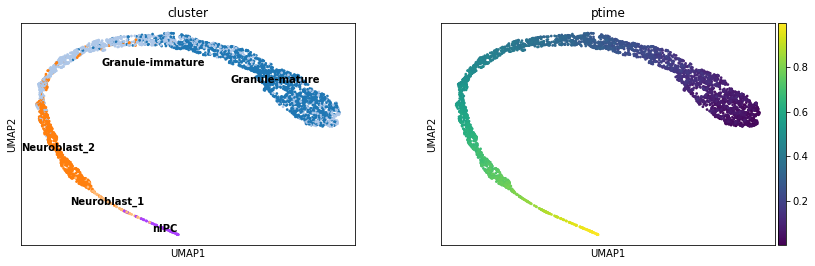

In [10]:
sc.pl.umap(adata, color=['cluster', 'ptime'], legend_loc='on data')

Since there exist two directions for integration when solving an ODE, the returned pseudotime estimate can be in the correct or reversed order. Although scTour takes into account the gene counts which are shown to be correlated with developmental potential, this rule does not apply to all data. scTour provides a post-inference function to reverse the pseudotime estimate when such cases occur.

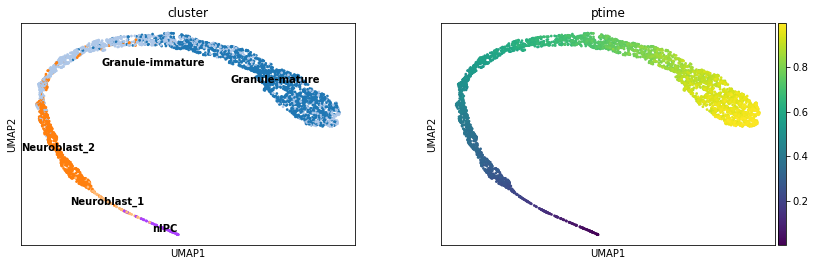

In [11]:
adata.obs['ptime'] = sct.train.reverse_time(adata.obs['ptime'].values)
sc.pl.umap(adata, color=['cluster', 'ptime'], legend_loc='on data')

Now the pseudotime follows the granule cell lineage development. To visualize the vector field, since the pseudotime is reversed, the vector field should be correspondingly reversed by setting the parameter `reverse` to be `True` when using the function `sct.vf.plot_vector_field`.

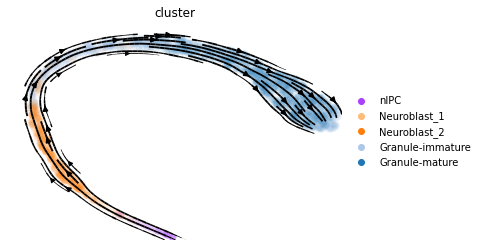

In [12]:
##infer the vector field
adata.obsm['X_VF'] = tnode.get_vector_field(adata.obs['ptime'].values, adata.obsm['X_TNODE'])

##visualize the vector field
sct.vf.plot_vector_field(adata, reverse=True, zs_key='X_TNODE', vf_key='X_VF', use_rep_neigh='X_TNODE', color='cluster', frameon=False, size=200, alpha=0.05)
plt.show()